# Part 1: Data Augmentation & Generalization Techniques

This notebook illustrates various regularization and data augmentation methods using TensorFlow/Keras.
We use the real **CIFAR-10 dataset** (32×32 color images) to demonstrate:
- Regularization using L1 and L2,
- Dropout and Monte Carlo dropout inference,
- EarlyStopping and TensorBoard callbacks,
- Data augmentation with Keras preprocessing layers and ImageDataGenerator,
- Additional experiments: different initializers, minimal hyperparameter tuning using Keras Tuner, KerasCV augmentation,
- A text augmentation stub using nlpaug,
- fastai data augmentation demonstration.

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras import layers, models, regularizers, callbacks
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## Data Augmentation using Keras Preprocessing Layers

We create an augmentation pipeline that randomly flips, rotates, and zooms images.

In [2]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])


## Load and Preprocess CIFAR-10 Data

We load the CIFAR-10 dataset (a real-world dataset) and scale pixels to [0,1].

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## Visualize Augmentation Effects (A/B Testing)

We select a real CIFAR-10 sample and display nine augmented versions.

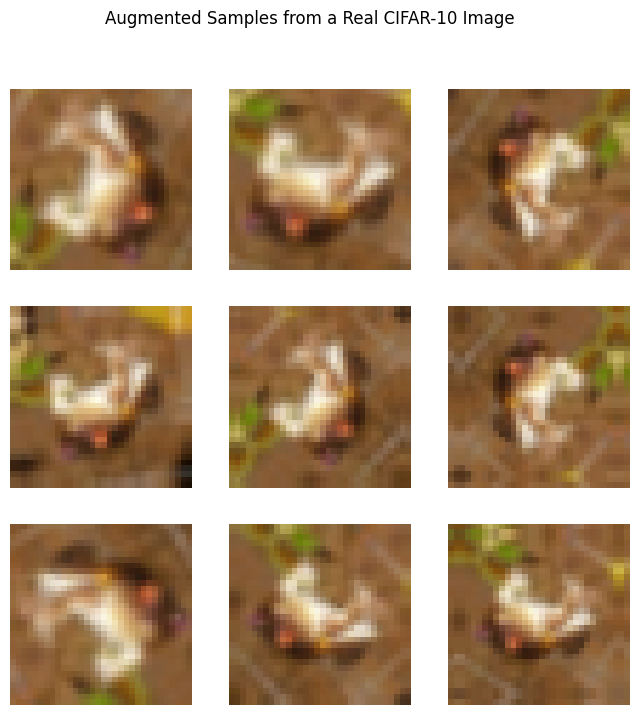

In [4]:
sample_image = x_train[0]

plt.figure(figsize=(8, 8))
for i in range(9):
    augmented_img = data_augmentation(tf.expand_dims(sample_image, axis=0))
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_img[0])
    plt.axis('off')
plt.suptitle("Augmented Samples from a Real CIFAR-10 Image")
plt.show()

## Build a Simple CNN with Regularization

The model includes:
- L1 regularization on the first Conv2D layer,
- L2 regularization on the second Conv2D layer,
- Dropout and BatchNormalization,
- The augmentation layer is used at the input.

In [5]:
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    data_augmentation,  # active only during training
    layers.Conv2D(32, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l1(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,106 (1.21 MB)

 Trainable params: 315,914 (1.21 MB)

 Non-trainable params: 192 (768.00 B)

## Train the Model with Callbacks

We use EarlyStopping to monitor loss and TensorBoard for visualization.

In [6]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)
tensorboard_cb = callbacks.TensorBoard(log_dir='./logs')

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=10,
                    batch_size=64,
                    callbacks=[early_stop, tensorboard_cb])

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.2036 - loss: 2.3498 - val_accuracy: 0.2928 - val_loss: 2.0543
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.2708 - loss: 2.0290 - val_accuracy: 0.3268 - val_loss: 1.8300
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3099 - loss: 1.9304 - val_accuracy: 0.4019 - val_loss: 1.6891
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3302 - loss: 1.8627 - val_accuracy: 0.4016 - val_loss: 1.6757
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3527 - loss: 1.8121 - val_accuracy: 0.3478 - val_loss: 1.8605
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3668 - loss: 1.7788 - val_accuracy: 0.4252 - val_loss: 1.6001
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3730 - loss: 1.7574 - val_accuracy: 0.3952 - val_loss: 1.8191
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3904 - loss: 1.7254 - val

## Plot Training History

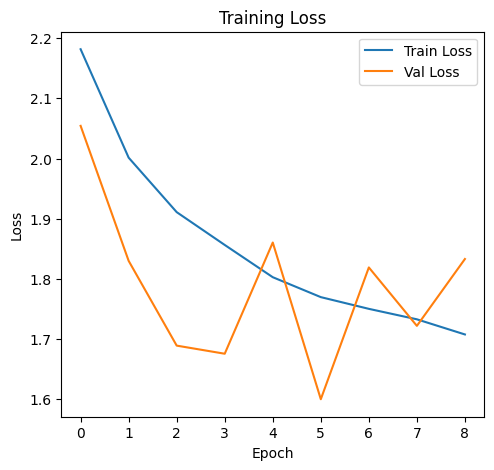

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

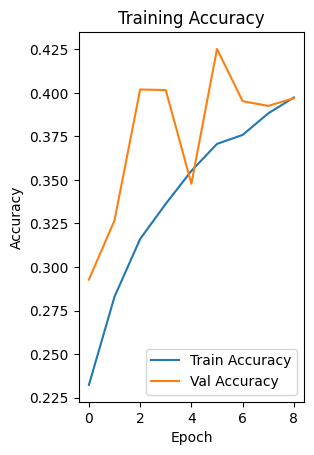

In [8]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Additional Experiments

### 1. Monte Carlo Dropout (MC Dropout) Inference

Demonstrate making predictions with dropout active at inference.

In [9]:
# Get predictions with dropout active (simulate Monte Carlo dropout)
mc_dropout_preds = model(x_test[:100], training=True).numpy()
print("MC Dropout predictions shape:", mc_dropout_preds.shape)

MC Dropout predictions shape: (100, 10)


### 2. Different Initializers Example

Build a small dense model using explicit initializers.

In [10]:
dense_model = models.Sequential([
    layers.Input(shape=(3072,)),
    layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(10, activation='softmax')
])
dense_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
dense_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,250 (1.53 MB)

 Trainable params: 402,250 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

### 3. Minimal Keras Tuner Example

A stub example for hyperparameter tuning using Keras Tuner.
(Ensure you have installed keras-tuner: `!pip install keras-tuner`)

In [11]:
try:
    import keras_tuner as kt
except ImportError:
    !pip install keras-tuner
    import keras_tuner as kt

def model_builder(hp):
    model = models.Sequential([
        layers.Input(shape=(32,32,3)),
        layers.Conv2D(
            filters=hp.Int('conv_filters', min_value=16, max_value=64, step=16),
            kernel_size=(3,3),
            activation='relu'
        ),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(model_builder,
                        objective='val_accuracy',
                        max_trials=3,
                        executions_per_trial=1,
                        directory='kt_dir',
                        project_name='cifar_tuning')
# Note: For brevity, we are not calling tuner.search() here; this is a stub.
print("Keras Tuner example setup complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00
Keras Tuner example setup complete.


### 4. KerasCV Data Augmentation Example

If available, demonstrate usage of KerasCV augmentation layers.
(Ensure keras_cv is installed: `!pip install keras-cv`)

In [12]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 46.0 MB/s eta 0:00:00


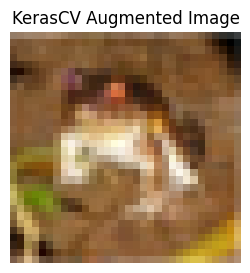

In [13]:
try:
    import keras_cv
    keras_cv_layer = keras_cv.layers.RandomFlip(mode="horizontal")
    # Apply keras_cv augmentation on one sample image
    augmented_cv = keras_cv_layer(tf.expand_dims(sample_image, axis=0))
    plt.figure(figsize=(3,3))
    plt.imshow(augmented_cv[0])
    plt.title("KerasCV Augmented Image")
    plt.axis('off')
    plt.show()
except ImportError:
    print("keras_cv not installed; run `!pip install keras-cv` in your Colab.")

### 5. Text Data Augmentation (Stub)

A minimal example using nlpaug for text. (Ensure you install nlpaug: `!pip install nlpaug`)

In [14]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 12.4 MB/s eta 0:00:00


In [15]:
try:
    import nlpaug.augmenter.word as naw
    import nltk # import nltk if it hasn't been already

    # Download the necessary NLTK resource
    nltk.download('averaged_perceptron_tagger_eng')
    text = "Deep learning models require a lot of data."
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text)
    print("Original:", text)
    print("Augmented:", augmented_text)
except ImportError:
    print("nlpaug not installed; run `!pip install nlpaug` in your Colab.")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Original: Deep learning models require a lot of data.
Augmented: ['Deep eruditeness modelling require a lot of data.']


### 6. fastai Data Augmentation Example

A code snippet using fastai's DataBlock API to demonstrate fastai augmentation.
(Ensure fastai is installed: `!pip install fastai`)

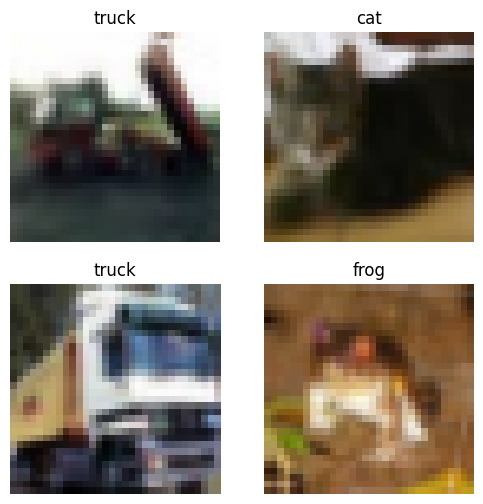

In [16]:
try:
    from fastai.vision.all import *
    # Use a small sample from CIFAR-10 (we will save a few images to disk temporarily)
    import os
    os.makedirs("fastai_sample", exist_ok=True)
    # Save first 10 images with labels (using CIFAR-10 labels)
    cifar_labels = ['airplane','automobile','bird','cat','deer',
                    'dog','frog','horse','ship','truck']
    for i in range(10):
        img = tf.keras.preprocessing.image.array_to_img(x_train[i])
        img.save(f"fastai_sample/{cifar_labels[y_train[i][0]]}_{i}.png")
    # Define a fastai DataBlock
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       get_y=using_attr(lambda x: os.path.basename(x).split('_')[0], "name"),
                       batch_tfms=aug_transforms(mult=1.0))
    dls = dblock.dataloaders("fastai_sample", bs=4)
    dls.show_batch(max_n=4)
except ImportError:
    print("fastai not installed; run `!pip install fastai` in your Colab.")


# Part 2: Advanced Keras Constructs

This notebook demonstrates advanced customizations in Keras using a real dataset.
We use the **Fashion MNIST** dataset and implement:
- A custom learning rate scheduler,
- A custom Huber loss function and custom metric (HuberMetric),
- A custom layer (ExponentialLayer),
- Additional custom components:
  - **MCAlphaDropout:** A dropout layer that applies dropout during both training and inference,
  - **MyDense:** A custom Dense layer with a manual max-norm constraint,
  - Custom activation (my_leaky_relu) and custom initializer (my_glorot_initializer),
  - **ResidualBlock:** A custom residual block with a skip connection,
  - **MyMomentumOptimizer:** A simplified custom optimizer (SGD with momentum).
- Integration of these custom components in a model,
- A custom training loop using tf.GradientTape.

These examples are run on Fashion MNIST—a compact, real-world dataset.
"""


In [18]:

# %% [code]
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0



## Load and Preprocess Fashion MNIST Data

Load Fashion MNIST (28x28 grayscale images) and scale to [0,1].


In [74]:

# %% [code]
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_test  = np.expand_dims(x_test, -1).astype("float32") / 255.0

# Add the channel dimension:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)

print(x_train.shape, x_test.shape)
# → (60000, 28, 28, 1) (10000, 28, 28, 1)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## Custom Learning Rate Scheduler

A step decay scheduler to adjust the learning rate during training.


In [55]:

# %% [code]
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

lr_scheduler = callbacks.LearningRateScheduler(step_decay)


## Custom Huber Loss Function


In [77]:

# %% [code]
def custom_huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < delta
    squared_loss = 0.5 * tf.square(error)
    linear_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, squared_loss, linear_loss)


## Custom Metric: HuberMetric

In [76]:

# %% [code]
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, delta=1.0, name="huber_metric", **kwargs):
        super(HuberMetric, self).__init__(name=name, **kwargs)
        self.delta = delta
        self.total_loss = self.add_weight(name="total_loss", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.delta
        squared_loss = 0.5 * tf.square(error)
        linear_loss = self.delta * (tf.abs(error) - 0.5 * self.delta)
        loss = tf.where(is_small_error, squared_loss, linear_loss)
        loss = tf.reduce_mean(loss)
        self.total_loss.assign_add(loss)
        self.count.assign_add(1.0)

    def result(self):
        return self.total_loss / self.count

    def reset_states(self):
        self.total_loss.assign(0.0)
        self.count.assign(0.0)


## Custom Layer: ExponentialLayer

A simple layer that returns the element-wise exponential of the input.

In [58]:

# %% [code]
class ExponentialLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(ExponentialLayer, self).__init__(**kwargs)
    def call(self, inputs):
        return tf.exp(inputs)


## Additional Custom Components

### 1. Custom Dropout (MCAlphaDropout)
This layer applies dropout during both training and inference (Monte Carlo dropout).

In [59]:

# %% [code]
class MCAlphaDropout(layers.Layer):
    def __init__(self, rate, **kwargs):
        super(MCAlphaDropout, self).__init__(**kwargs)
        self.rate = rate
    def call(self, inputs, training=None):
        # Always apply dropout (simulate MC Dropout)
        return tf.nn.dropout(inputs, rate=self.rate)


### 2. Custom Dense Layer with MaxNorm Constraint (MyDense)
A Dense layer that enforces a maximum norm on the kernel weights.

In [60]:

# %% [code]
class MyDense(layers.Layer):
    def __init__(self, units, max_norm=3.0, **kwargs):
        super(MyDense, self).__init__(**kwargs)
        self.units = units
        self.max_norm = max_norm

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(int(input_shape[-1]), self.units),
            initializer='glorot_uniform',
            trainable=True,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, inputs):
        kernel = tf.clip_by_norm(self.kernel, clip_norm=self.max_norm, axes=[0])
        return tf.matmul(inputs, kernel) + self.bias


### 3. Custom Activation Function and Initializer

Define a custom leaky ReLU and a modified Glorot initializer.

In [61]:

# %% [code]
def my_leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

def my_glorot_initializer(shape, dtype=None):
    fan_in, fan_out = shape[0], shape[1]
    limit = tf.sqrt(6.0 / (fan_in + fan_out))
    return tf.random.uniform(shape, minval=-limit, maxval=limit, dtype=dtype)


### 4. Custom Residual Block (ResidualBlock)

A simple residual block with skip connections.

In [62]:

# %% [code]
class ResidualBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(filters, kernel_size, padding="same", activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, kernel_size, padding="same")
        self.bn2 = layers.BatchNormalization()
        self.activation = layers.Activation('relu')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = layers.add([x, inputs])
        return self.activation(x)


### 5. Custom Optimizer (MyMomentumOptimizer)

A simplified custom optimizer based on SGD with momentum.
The learning_rate and momentum are now cast to float.
Note: This is a minimal demonstration and not for production.

In [90]:
import keras
from keras import ops

class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)
        self.momentum = momentum

    def build(self, variables):
        # Create momentum variables for each trainable variable
        self.momentums = []
        for var in variables:
            self.momentums.append(
                self.add_variable_from_reference(
                    reference_variable=var, name="momentum"
                )
            )

    def update_step(self, gradient, variable):
        # Find the index of the variable to get its corresponding momentum
        var_index = self._get_variable_index(variable)
        momentum_var = self.momentums[var_index]

        # Update momentum
        momentum_var.assign(self.momentum * momentum_var - self.learning_rate * gradient)

        # Update variable
        variable.assign_add(momentum_var)

    def get_config(self):
        config = super().get_config()
        config.update({
            "learning_rate": self.learning_rate,
            "momentum": self.momentum,
        })
        return config

    def _get_variable_index(self, variable):
        """Find the index of the given variable in the list of trainable variables."""
        return self.trainable_variables.index(variable) # Added this line for fix.

## Build a Model Integrating the Custom Components

We construct an advanced model that uses:
- A custom Conv2D layer using a custom leaky ReLU activation and custom initializer,
- A ResidualBlock,
- A Flatten followed by a custom Dense layer (MyDense),
- MCAlphaDropout,
- And a final Dense classifier.
This model is compiled using our custom optimizer.

In [91]:

# %% [code]
def build_advanced_model(input_shape=(28,28,1), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding="same",
                      activation=lambda z: my_leaky_relu(z, alpha=0.2),
                      kernel_initializer=my_glorot_initializer)(inputs)
    x = ResidualBlock(32)(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = MyDense(64, max_norm=3.0)(x)
    x = MCAlphaDropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

advanced_model = build_advanced_model(input_shape=(28,28,1), num_classes=10)
optimizer = MyMomentumOptimizer(learning_rate=0.01, momentum=0.9)
advanced_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
advanced_model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_17               │ (None, 28, 28, 32)     │        18,752 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense_17 (MyDense)           │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_alpha_dropout_17             │ (None, 64)             │             0 │
│ (MCAlphaDropout)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,194 (1.61 MB)

 Trainable params: 421,066 (1.61 MB)

 Non-trainable params: 128 (512.00 B)

## Train the Advanced Model on Fashion MNIST

We train on Fashion MNIST for 5 epochs as a demonstration.

In [68]:
# Build the advanced model
advanced_model = build_advanced_model()

# Instantiate a new optimizer for this model
advanced_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Compile the model with the new optimizer
advanced_model.compile(
    optimizer=advanced_optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    run_eagerly=True  # Enable eager execution for debugging
)

# Train the model
history_adv = advanced_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5,
    batch_size=128
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.7238 - loss: 1.6399 - val_accuracy: 0.8571 - val_loss: 0.4144
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.8729 - loss: 0.3610 - val_accuracy: 0.8778 - val_loss: 0.3556
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - accuracy: 0.8909 - loss: 0.3062 - val_accuracy: 0.8849 - val_loss: 0.3296
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.9024 - loss: 0.2774 - val_accuracy: 0.8969 - val_loss: 0.2982
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.9106 - loss: 0.2536 - val_accuracy: 0.8969 - val_loss: 0.2978


## Custom Training Loop Example

This section demonstrates one epoch of training using a custom loop with tf.GradientTape.

In [105]:
import tensorflow as tf

# Hyperparams
learning_rate = 0.01
momentum      = 0.9

# 1) Build & compile with any optimizer (we won’t actually use it)
advanced_model = build_advanced_model(input_shape=(28,28,1), num_classes=10)
advanced_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate),
    loss=custom_huber_loss,
    metrics=["accuracy", HuberMetric(delta=1.0)],
    run_eagerly=True
)

# 2) Prepare your data
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(96)

# 3) Create “momentum buffers” for every trainable variable
momentum_vars = [
    tf.Variable(tf.zeros_like(var), trainable=False)
    for var in advanced_model.trainable_variables
]

# 4) Custom training step (no Keras Optimizer.apply_gradients at all)
def train_step(x, y):
    with tf.GradientTape() as tape:
        preds = advanced_model(x, training=True)
        loss  = tf.reduce_mean(custom_huber_loss(tf.one_hot(y,10), preds))
    grads = tape.gradient(loss, advanced_model.trainable_variables)

    # Manually apply SGD+momentum
    for var, grad, m in zip(advanced_model.trainable_variables, grads, momentum_vars):
        new_m = momentum * m - learning_rate * grad
        m.assign(new_m)
        var.assign_add(new_m)

    return loss

# 5) Run your loop
total_loss  = 0.0
batch_count = 0
for xb, yb in train_ds:
    l = train_step(xb, yb)
    total_loss += l.numpy()
    batch_count += 1

print("Average loss:", total_loss / batch_count)

Average loss: 0.018702107


## Plot Advanced Model Training History

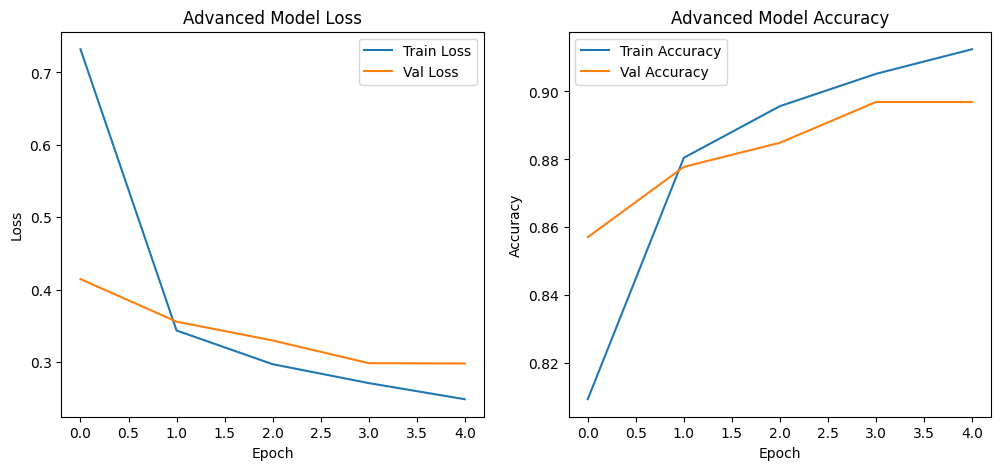

In [106]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_adv.history["loss"], label="Train Loss")
plt.plot(history_adv.history["val_loss"], label="Val Loss")
plt.title("Advanced Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_adv.history["accuracy"], label="Train Accuracy")
plt.plot(history_adv.history["val_accuracy"], label="Val Accuracy")
plt.title("Advanced Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()